In [1]:
pip install deap

     |████████████████████████████████| 153kB 2.8MB/s 


In [2]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz, ngf):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

class Classifier_B(nn.Module):
    def __init__(self):
        super(Classifier_B, self).__init__()

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 64, kernel_size=8, stride = 2, padding = 3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=6, stride = 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels = 128, kernel_size=5, stride = 1)
        self.dropout2 = nn.Dropout(0.5)
        self.FC1 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        in_size = x.size(0)
        x = self.dropout1(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.dropout2(x)
        x = x.view(in_size, -1)
        x = self.FC1(x)
        return x
    
    def get_output(self, x):
        in_size = x.size(0)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(in_size, -1)
        x = self.FC1(x)
        return x

In [165]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Hyper parameters
params = {
    'input_size': 28,  # image size 1x64x64
    'batch_size': 64,  # batch size
    'pop_size': 100,   # population size
    'nc': 1,  # number of channels
    'nz': 100,  # size of z latent vector
    'ngf': 64,  # size of feature maps in generator
    'ndf': 32,  # size of feature maps in discriminator
    'num_epochs': 1000,  # number of epochs
    'lr': 0.0001,  # learning rate
    'beta1': 0.5,   # beta1 for adam optimizer
    'ngpu': 1,  # number of GPU
    'lambda_gp': 10,  # loss weight for gradient penalty
    'n_critic': 5,
}

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Generator(ngpu, nc, nz, ngf)
# 이 부분에서 체크포인트 위치 설정.
netG = Generator(params['ngpu'], params['nc'], params['nz'], params['ngf'])
netG.load_state_dict(torch.load(gdrive_root + '/checkpoints/netG_12500.pth', map_location=torch.device('cpu')))

# transform
transform = transforms.Compose([transforms.ToTensor()])

# data sets and data loader
train_data = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_data, params['batch_size'], shuffle=False)
first_batch = train_data_loader.__iter__().__next__()  # first batch of MNIST data set : torch.Size([64x, 1, 28, 28])
print(first_batch[0][0].shape)  # torch.Size([1, 28, 28])
#imshow(first_batch[0][0])  # plot the image of first batch

torch.Size([1, 28, 28])


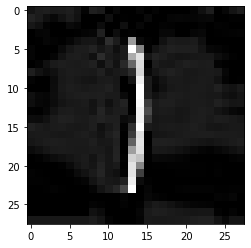

torch.Size([1, 28, 28])


In [157]:
from PIL import Image
import torchvision.transforms.functional as TF

my_image = Image.open(gdrive_root + '/my_data/0.1_1to7.jpg')
my_x = TF.to_tensor(my_image)

imshow(my_x)
print(my_x.size())

In [0]:
# Input image for defense GAN
# For the test purpose, we will use MNIST data sample first.
# fgsm_image : torch.Size([1, 28, 28]). This is image x.
#fgsm_image = first_batch[0][0]  # torch.Size([1, 28, 28]). This should be fgsm_image later on.
fgsm_image = my_x
# evalFunc 에서 numpy 형태로 계산하려고 모양 수정 / 일단은 그냥 28, 28로 했는데 나중엔 일렬로 계산해도 될 듯.
x = fgsm_image.view(28,28).numpy()
#imshow(fgsm_image)

# individual은 numpy array
# numpy array 가 들어오면 -> tensor로 바꾸고, netG input 모양에 맞춰줌.
# netG의 output이 tensor 형태이므로, numpy로 바꿔서 계산.. (이부분 텐서 형태에서 계산으로 추후 수정하면 될 듯.)
def evalFunc(individual):
    individual = torch.from_numpy(individual).view(1, 100, 1, 1)
    return np.linalg.norm(netG(individual).view(28, 28).detach().numpy() - x, ord=2)**2,

# Initial population for GA
# initial_population : torch.Size([100, 100, 1, 1]), This has 100 latent vectors z (z is torch.Size([100, 1, 1])).
# for example, initial_population[0] is z_0, initial_population[1] is z_1, ..., initial_population[99] is z_99.
initial_population = torch.FloatTensor(params['pop_size'], params['nz'], 1, 1).normal_(0, 1)
#print(initial_population.shape)  # torch.Size([100, 100, 1, 1])


# 이 부분은 evalFunc 이 잘 작동하는지 확인하는 부분입니당.
# z 가 길이 100짜리 1차원 numpy array 라고 가정하고(GA 에서 기본 individual 형태) evalFunc에 넣은뒤, 출력
# z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)
# z = z.view(100).numpy()
# print(evalFunc(z))

# initial_population를 numpy로 타입 맞춰주기.
initial_population = initial_population.view(100, 100).numpy()

def initIndividual(icls, content):
  return icls(content)

def initPopulation(pcls, ind_init):
  return pcls(ind_init(c) for c in initial_population)

In [159]:
import random
from deap import creator, base, tools, algorithms

# TOCHECK:  will we use algorithm modules?

'''
Fitness : single optimization, minimize ||G(z) - x||^2_2
'''
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin) # minimizing the fitness value

toolbox = base.Toolbox()

'''
[HYPERPARAMETERS]
List of Floats: individuals composed of 'IND_SIZE' floating point numbers
IND_SIZE: z의 dimension으로 보면 될듯
POPULATION
CXPB: probability of crossover
MUTPB: probability of mutation
'''
IND_SIZE = 100
POPULATION = 10
CXPB, MUTPB = 0.4, 0.2
GENERATIONS = 100

toolbox.register("attr_float", random.random)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
toolbox.register("individual", initIndividual, creator.Individual)
toolbox.register("population", initPopulation, list, toolbox.individual)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [0]:
def cxTwoPointCopy(ind1, ind2):
    """Execute a two points crossover with copy on the input individuals. The
    copy is required because the slicing in numpy returns a view of the data,
    which leads to a self overwritting in the swap operation. It prevents
    ::
    
        >>> import numpy
        >>> a = numpy.array((1,2,3,4))
        >>> b = numpy.array((5,6,7,8))
        >>> a[1:3], b[1:3] = b[1:3], a[1:3]
        >>> print(a)
        [1 6 7 4]
        >>> print(b)
        [5 6 7 8]
    """
    size = len(ind1)
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2].copy(), ind1[cxpoint1:cxpoint2].copy()
        
    return ind1, ind2

In [0]:
'''
Evaluation Function: ||G(z) - x||^2_2 <- use 'np.linalg.norm( , ord=2)**2'
'''
# TODO : need to change mate, mutate, select operator
# can check in here : https://deap.readthedocs.io/en/master/api/tools.html
toolbox.register("evaluate", evalFunc)
#toolbox.register("mate", cxTwoPointCopy)
toolbox.register("mate", tools.cxUniform, indpb=0.1)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [162]:
import os
my_classifier = Classifier_B()
best_acc = 0.0
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
ckpt_path = os.path.join(ckpt_dir, 'modelB_ckpt.pt')
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path)
    try:
        my_classifier.load_state_dict(ckpt['model'])
        best_acc = ckpt['best_acc']
    except RuntimeError as e:
        print('wrong checkpoint')
    else:    
        print('checkpoint is loaded !')
        print('current best accuracy : %.2f' % best_acc)

checkpoint is loaded !
current best accuracy : 0.98


In [0]:
def main():
    random.seed(777)

    # pop = toolbox.population(n=POPULATION)
    pop = toolbox.population()
    
    print("Start of evolution")

    # Evaluate the entire population
    # print(fitnesses) -> [(84,), (105,), (96,), (104,), (94,),  ... ] 이런식으로 저장됨.
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while min(fits) > 10 and g < GENERATIONS:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        
        # Select the next generation individuals
        # len(pop) -> 50, len(pop[0]) -> 5
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        '''
        they modify those individuals within the toolbox container 
        and we do not need to reassign their results.
        '''
        # TODO: want p_new1 = p_m - beta(p_m - p_d), p_new2 = p_m + beta(p_m - p_d)
        # want to customize mutation method... there is no proper mutation operator in deap.tools...

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                size = min(len(child1), len(child2))
                for i in range(5):                    
                  cxpoint = random.randint(2, size - 1)
                  mtpoint = cxpoint - 1
                  # cxpoint -1 위치 : mutate
                  beta = random.random()
                  child1[mtpoint] = child1[mtpoint] - beta*(child1[mtpoint] - child2[mtpoint])
                  child2[mtpoint] = child1[mtpoint] + beta*(child1[mtpoint] - child2[mtpoint])

                  # crossover : one point crossover (temporary crossover algorithm)
                  # child1[cxpoint:], child2[cxpoint:] = child2[cxpoint:], child1[cxpoint:]
                del child1.fitness.values
                del child2.fitness.values

        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        to_classify = tools.selBest(pop, 1)[0]
        to_classify2 = torch.from_numpy(to_classify).view(1, 100, 1, 1)
        to_classify3 = netG(to_classify2)
        to_classify4 = my_classifier.get_output(to_classify3.view(1, 1, 28, 28))[0]
        print(to_classify4)
        print(to_classify4.max(0)[1])


        if g % 10 == 0 :
          best_ind = tools.selBest(pop, 1)[0]
          #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
          print(best_ind.fitness.values)
          z = torch.from_numpy(best_ind).view(1, 100, 1, 1)
          gen_image = netG(z)
          #print(netG(z))
          imshow(fgsm_image)
          imshow(gen_image.detach())


    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    print(best_ind.fitness.values)
    return best_ind
# main()

Start of evolution
-- Generation 1 --
  Min 19.272944536305886
  Max 53.50564714347365
  Avg 35.59085601059554
  Std 7.180853373635144
tensor([-3.4706,  6.7783,  2.2795, -3.2044, -1.8590,  0.5495,  1.4500,  0.2712,
         2.2615, -1.5709], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 2 --
  Min 19.119306185766845
  Max 46.969702559914595
  Avg 31.033555878312736
  Std 6.159658209524635
tensor([-4.8110, 11.9088, -2.0926, -1.3950,  1.8697, -3.1958, -0.1646,  2.2316,
        -0.0741,  0.4805], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 3 --
  Min 18.17726330035748
  Max 45.541259380701376
  Avg 28.712338409367167
  Std 5.467961837035322
tensor([-4.3753, 10.9611, -2.1503, -1.6525,  1.5955, -2.3587,  0.1075,  1.6829,
         0.0827,  0.6603], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 4 --
  Min 18.0110904332671
  Max 55.76356650505113
  Avg 27.095622154495878
  Std 6.235130669895286
tensor([-4.3268, 10.3210, -2.5253, -1.3820,  1.5901, -1.2254,  0.7214,  0.7561,
      

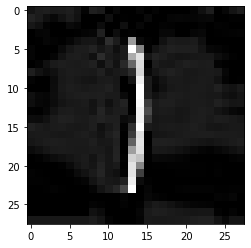

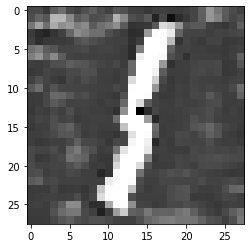

-- Generation 11 --
  Min 17.464494510146324
  Max 45.99604877447655
  Avg 20.08198591277956
  Std 4.289621163581945
tensor([-4.9197,  7.5115, -4.1273,  0.7876,  1.8300,  0.8148, -0.6868,  1.1744,
        -1.2641,  2.9299], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 12 --
  Min 17.393092459243235
  Max 37.53818147581319
  Avg 20.03637114562753
  Std 3.8185459811798115
tensor([-3.6712,  9.7548, -1.6876, -1.4031,  0.5434, -1.2423,  1.0605,  1.1983,
         0.0723, -0.4034], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 13 --
  Min 17.36741255603215
  Max 30.29322546023559
  Avg 18.70594398940799
  Std 2.4598583306926045
tensor([-3.5488,  9.6270, -1.6596, -1.3826,  0.4580, -0.9912,  1.3162,  0.6748,
         0.3113, -0.5816], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 14 --
  Min 17.33623575106344
  Max 32.49957122710134
  Avg 17.906401890140405
  Std 1.569597416394338
tensor([-3.3837,  9.4736, -1.5316, -1.3225,  0.2420, -0.8423,  1.4158,  0.5138,
         0.4639, -0.80

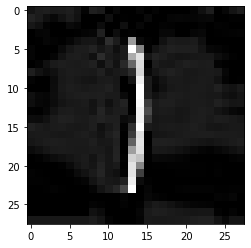

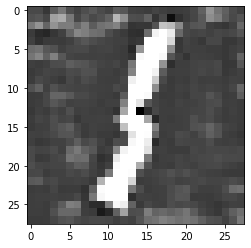

-- Generation 21 --
  Min 16.925755864378743
  Max 19.64833608622962
  Avg 17.350414428784006
  Std 0.33491641291813734
tensor([-3.6204,  9.6695, -1.7212, -1.3727,  0.4418, -1.0481,  1.1191,  0.9766,
         0.1272, -0.3668], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 22 --
  Min 16.925755864378743
  Max 17.878969291587282
  Avg 17.233580716469035
  Std 0.15768810974529554
tensor([-3.6204,  9.6695, -1.7212, -1.3727,  0.4418, -1.0481,  1.1191,  0.9766,
         0.1272, -0.3668], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 23 --
  Min 16.885971396814284
  Max 18.409005423646022
  Avg 17.17843413116276
  Std 0.2024970072572408
tensor([-3.7496,  9.8694, -1.7977, -1.2906,  0.6780, -1.3981,  0.7231,  1.2303,
         0.0939, -0.0819], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 24 --
  Min 16.879713508832538
  Max 18.06280803811751
  Avg 17.093438847588303
  Std 0.1800806142111987
tensor([-3.6396,  9.6854, -1.7086, -1.3748,  0.4468, -1.1101,  0.9835,  1.0530,
         0.1

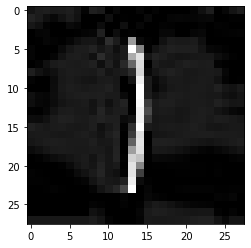

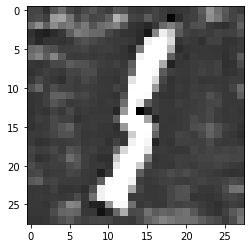

-- Generation 31 --
  Min 16.53965052078115
  Max 17.326397516728548
  Avg 16.80412645449012
  Std 0.1326821677634731
tensor([-3.6558,  9.1919, -1.9899, -0.9573,  0.5096, -0.5176,  1.0668,  0.5737,
         0.1059, -0.1327], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 32 --
  Min 16.609113456812338
  Max 17.41508194914445
  Avg 16.777259204157716
  Std 0.1562052311990446
tensor([-3.6896,  8.7882, -2.2280, -0.5355,  0.5110, -0.0404,  1.0856,  0.4128,
        -0.0321, -0.0764], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 33 --
  Min 16.568220207249396
  Max 17.4135537338409
  Avg 16.759580980388584
  Std 0.1472110873115096
tensor([-3.8474,  9.1925, -2.2317, -0.6561,  0.6674, -0.4226,  0.8571,  0.6789,
        -0.0869,  0.1176], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 34 --
  Min 16.565312834069346
  Max 18.418102636500407
  Avg 16.76970636004185
  Std 0.23903889976249676
tensor([-3.9896,  9.6643, -2.1147, -0.8797,  0.9094, -1.3129,  0.2018,  1.5262,
        -0.1087,

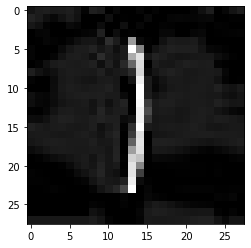

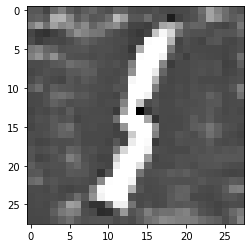

-- Generation 41 --
  Min 16.199140287085356
  Max 16.846159370369605
  Avg 16.477552840111862
  Std 0.12484647128563194
tensor([-3.8475,  9.0667, -2.1716, -0.5510,  0.5617, -0.4676,  0.5902,  0.9726,
        -0.0993,  0.1874], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 42 --
  Min 16.223688236061435
  Max 17.845386522342096
  Avg 16.48404521435627
  Std 0.23416204334060658
tensor([-3.8527,  9.0048, -2.2092, -0.4308,  0.5285, -0.3297,  0.6183,  0.8748,
        -0.1185,  0.1654], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 43 --
  Min 16.217135690469377
  Max 16.730465051697138
  Avg 16.388885055624836
  Std 0.12059144866757236
tensor([-3.8727,  9.1286, -2.1628, -0.5580,  0.5573, -0.4808,  0.6245,  0.9728,
        -0.1061,  0.1553], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 44 --
  Min 16.166684007680487
  Max 16.681584728467897
  Avg 16.34549854613134
  Std 0.12168609866633699
tensor([-3.9073,  8.8087, -2.3785, -0.0819,  0.6631, -0.2392,  0.4211,  0.8572,
        -

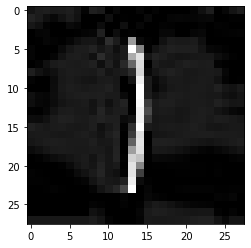

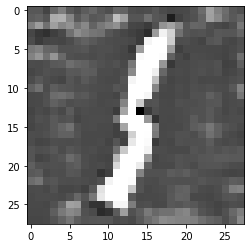

-- Generation 51 --
  Min 16.046641913425447
  Max 16.686835737972615
  Avg 16.226996351400132
  Std 0.1289140220091123
tensor([-3.9192e+00,  8.6965e+00, -2.4513e+00, -9.2953e-02,  6.2839e-01,
        -5.3897e-03,  6.0522e-01,  8.0908e-01, -2.7954e-01,  2.8103e-01],
       grad_fn=<SelectBackward>)
tensor(1)
-- Generation 52 --
  Min 16.087609683574783
  Max 17.13551668686364
  Avg 16.22478993478429
  Std 0.1520312289936661
tensor([-3.9155,  8.7328, -2.4298, -0.1736,  0.6474, -0.0720,  0.6157,  0.8518,
        -0.2729,  0.2826], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 53 --
  Min 16.065756509666244
  Max 16.679041324374566
  Avg 16.17914290041716
  Std 0.10504272466417834
tensor([-3.9141,  8.6702, -2.4595, -0.1066,  0.6349,  0.0361,  0.6630,  0.7699,
        -0.2812,  0.2557], grad_fn=<SelectBackward>)
tensor(1)
-- Generation 54 --
  Min 16.073100425046732
  Max 16.658043258390535
  Avg 16.169231808237143
  Std 0.10270078581508113
tensor([-3.9671,  8.7426, -2.4838,  0.0654,  

KeyboardInterrupt: ignored

In [167]:
# For each generation, select the latent vector z* that minimizes fitness, and do the following.
# z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)  # torch.Size([100, 1, 1]). This should be z* later on.
output = np.array(main())

z = torch.from_numpy(output).view(1, 100, 1, 1)

gen_image = netG(z)  # torch.Size([1, 28, 28]). This is the generated image that we want to see for each generation.
# Because gen_image should step closer to fgsm_image x for each generation.

print("the shape of generated image : " + str(gen_image.shape))
imshow(gen_image.detach())  # plot the image of generated image





print(my_classifier(gen_image.view(1, 1, 28, 28)))

# After GA, give generated image as input to each classifier (use gen_image)

In [168]:
#print(gen_image)
print(my_classifier.get_output(gen_image.view(1, 1, 28, 28)))
temp = my_classifier.get_output(gen_image.view(1, 1, 28, 28))[0]
#temp = my_classifier(fgsm_image.view(1, 1, 28, 28))[0]
print(temp)
print(temp.max(0)[1])
#print(gen_image)

tensor([[-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
          2.3648,  0.0825]], grad_fn=<AddmmBackward>)
tensor([-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
         2.3648,  0.0825], grad_fn=<SelectBackward>)
tensor(1)


In [169]:
for i in range(10):
  temp = my_classifier.get_output(fgsm_image.view(1, 1, 28, 28))[0]
  print(temp)
  print(temp.max(0)[1])

tensor([-0.8642,  1.5102,  0.3425,  0.5399, -0.7936, -0.9937, -1.4123,  1.5697,
         1.0592,  0.1807], grad_fn=<SelectBackward>)
tensor(7)
tensor([-0.8642,  1.5102,  0.3425,  0.5399, -0.7936, -0.9937, -1.4123,  1.5697,
         1.0592,  0.1807], grad_fn=<SelectBackward>)
tensor(7)
tensor([-0.8642,  1.5102,  0.3425,  0.5399, -0.7936, -0.9937, -1.4123,  1.5697,
         1.0592,  0.1807], grad_fn=<SelectBackward>)
tensor(7)
tensor([-0.8642,  1.5102,  0.3425,  0.5399, -0.7936, -0.9937, -1.4123,  1.5697,
         1.0592,  0.1807], grad_fn=<SelectBackward>)
tensor(7)
tensor([-0.8642,  1.5102,  0.3425,  0.5399, -0.7936, -0.9937, -1.4123,  1.5697,
         1.0592,  0.1807], grad_fn=<SelectBackward>)
tensor(7)
tensor([-0.8642,  1.5102,  0.3425,  0.5399, -0.7936, -0.9937, -1.4123,  1.5697,
         1.0592,  0.1807], grad_fn=<SelectBackward>)
tensor(7)
tensor([-0.8642,  1.5102,  0.3425,  0.5399, -0.7936, -0.9937, -1.4123,  1.5697,
         1.0592,  0.1807], grad_fn=<SelectBackward>)
tensor(7)

In [138]:
for i in range(10):
  temp = my_classifier.get_output(gen_image.view(1, 1, 28, 28))[0]
  print(temp)
  print(temp.max(0)[1])

tensor([-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
         2.3648,  0.0825], grad_fn=<SelectBackward>)
tensor(1)
tensor([-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
         2.3648,  0.0825], grad_fn=<SelectBackward>)
tensor(1)
tensor([-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
         2.3648,  0.0825], grad_fn=<SelectBackward>)
tensor(1)
tensor([-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
         2.3648,  0.0825], grad_fn=<SelectBackward>)
tensor(1)
tensor([-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
         2.3648,  0.0825], grad_fn=<SelectBackward>)
tensor(1)
tensor([-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
         2.3648,  0.0825], grad_fn=<SelectBackward>)
tensor(1)
tensor([-4.1442,  8.1612,  0.0329, -2.6226,  0.0901, -2.2889, -0.7406,  2.5252,
         2.3648,  0.0825], grad_fn=<SelectBackward>)
tensor(1)